In [1]:
# Basics
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# TensorFlow/Keras (Keras layers and optimizers below)
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

# sklearn
from sklearn.model_selection import KFold

# Custom
import sys
sys.path.insert(0, '../src/utils')
from trace_handler import TraceHandler
import constants
from single_byte_evaluator import SingleByteEvaluator
sys.path.insert(0, '../src/modeling')
from network import Network

# Suppress TensorFlow messages
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # 1 for INFO, 2 for INFO & WARNINGs, 3 for INFO & WARNINGs & ERRORs

In [2]:
# Train
train_th = TraceHandler('/prj/side_channel/PinataTraces/CURR/D1-K1_50k_500MHz + Resampled at 168MHz.trs')    
    
BYTE_IDX = 0
N_CLASSES = 256

x_train_tot = train_th.get_traces()
y_train_tot = train_th.get_specific_labels(BYTE_IDX)
y_train_tot = to_categorical(y_train_tot, N_CLASSES)

# Test
test_th = TraceHandler('/prj/side_channel/PinataTraces/CURR/D1-K2_50k_500MHz + Resampled at 168MHz.trs')

x_test, y_test = test_th.generate_test(BYTE_IDX) 
y_test = to_categorical(y_test, N_CLASSES)

test_plaintexts = test_th.get_plaintexts()
true_key_byte = test_th.get_key()[BYTE_IDX]

Labeling traces: 100%|██████████| 50000/50000 [00:21<00:00, 2308.94it/s]


In [3]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization

HP_CHOICES = {#'kernel_initializer': ['random_normal', 'random_uniform', 
              #                       'truncated_normal', 
              #                       'zeros', 'ones', 
              #                       'glorot_normal', 'glorot_uniform',
              #                       'he_normal', 'he_uniform',
              #                       'identity', 'orthogonal', 'constant', 'variance_scaling'],
              'kernel_initializer': ['random_normal', 'random_uniform', 'he_normal', 'he_uniform'],  
              'activation':         ['relu', 'tanh'],
              'hidden_layers':      [3, 4, 5],
              'hidden_neurons':     [200, 300, 400, 500],
              'dropout_rate':       [0.0, 0.2, 0.4],
              'optimizer':          [SGD, Adam, RMSprop],
              'learning_rate':      [1e-3, 1e-4, 1e-5],
              'batch_size':         [100, 200, 500, 1000]}    

def build_model(kernel_initializer, 
                activation, 
                hidden_layers, 
                hidden_neurons, 
                dropout_rate, 
                optimizer,
                learning_rate,
                batch_size):
    
    model = Sequential()
    
    # Input
    model.add(Dense(constants.TRACE_LEN,
                    kernel_initializer=kernel_initializer,
                    activation=activation))

    # First BatchNorm
    model.add(BatchNormalization())

    # Hidden
    for _ in range(hidden_layers):
        model.add(Dense(hidden_neurons,
                        kernel_initializer=kernel_initializer,
                        activation=activation))

        # Dropout
        model.add(Dropout(dropout_rate))

    # Second BatchNorm
    model.add(BatchNormalization())

    # Output
    model.add(Dense(256, activation='softmax')) ########################### 256 to be changed if the target is changed (HW, ...)

    # Compilation
    model.compile(optimizer=optimizer(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [4]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

estimator = KerasClassifier(build_model, verbose=1)

grid = GridSearchCV(estimator,
                    # n_jobs=-1,
                    verbose=1,
                    return_train_score=True,
                    cv=10,
                    param_grid=HP_CHOICES)

grid_result = grid.fit(x_train_tot, y_train_tot)

450/450 [==============================] - 1s 1ms/step - loss: 5.3051 - accuracy: 0.0186


KeyboardInterrupt: 

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = []
callbacks.append(EarlyStopping(monitor='val_loss', 
                               patience=5))
callbacks.append(ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=3,
                                   min_lr=1e-7))

In [ ]:
from sklearn.model_selection import cross_validate


N_EXP = 10
EPOCHS = 300

for model in models:
    net, net_hp = model
    net = 

In [7]:
rev = True

if METRIC == 'LOSS':
    rev = False
    
results.sort(key=lambda x: x[1], reverse=rev)
print()
print(f'K-Fold Crossvalidation Results: {[(idx, loss) for idx, loss, _ in results]}')


K-Fold Crossvalidation Results: [(17, 0.903700003027916), (12, 0.5949400067329407), (6, 0.21301999874413013), (0, 0.20499999970197677), (11, 0.06648000022396446), (13, 0.06000000014901161), (2, 0.0575399998575449), (9, 0.05130000011995435), (7, 0.03784000016748905), (16, 0.034999999962747094), (3, 0.007779999962076544), (5, 0.006280000042170286), (15, 0.004679999966174364), (10, 0.00463999998755753), (19, 0.004419999965466559), (18, 0.004359999974258244), (4, 0.0041999999899417165), (14, 0.003920000023208558), (8, 0.0038200000301003454), (1, 0.003639999986626208)]


In [8]:
best_net, best_net_hp = models[results[0][0]]
best_net_histories = results[0][2]

# f, ax = plt.subplots(2, 1, figsize=(10, 10))

# tot_train_acc = np.array([history.history['accuracy'] for history in best_net_histories], dtype=object) # object because not all histories have same length (EarlyStopping)
# avg_train_acc = np.mean(tot_train_acc, axis=0)

# for history in best_net_histories:
#     ax[0].plot(history.history['accuracy'], label='train_acc',color='r')
#     ax[0].plot(history.history['val_accuracy'], label='val_acc',color='b')
#     ax[0].set_xlabel('Epochs')
#     ax[0].set_ylabel('Accuracy')
#     ax[0].legend()
#     ax[0].grid()
    
#     ax[1].plot(history.history['loss'], label='train_loss', color='r')
#     ax[1].plot(history.history['val_loss'], label='val_loss', color='b')
#     ax[1].set_xlabel('Epochs')
#     ax[1].set_ylabel('Loss')
#     ax[1].legend()
#     ax[1].grid()
    
# plt.show()

In [9]:
best_net_hp

{'kernel_initializer': 'he_normal',
 'activation': 'relu',
 'hidden_layers': 4,
 'hidden_neurons': 600,
 'dropout_rate': 0.0,
 'optimizer': keras.optimizer_v2.adam.Adam,
 'learning_rate': 0.001,
 'batch_size': 1000}

In [10]:
def ge_random_no_split(n_exp, hp, x_train_tot, y_train_tot, x_test, test_plaintexts, true_key_byte, byte_idx):
    
    network = build_model(hp)
    network.fit(x_train_tot,
                y_train_tot,
                epochs=200,
                batch_size=hp['batch_size'],
                verbose=1)
   
    num_test_traces = len(x_test)
    
    tr_pltxt = list(zip(x_test, test_plaintexts))

    ranks = []
    for i in tqdm(range(n_exp)):
        
        random.shuffle(tr_pltxt)
        curr_x_test = np.array([tr for tr, _ in tr_pltxt])
        curr_test_platintexts = [pl for _, pl in tr_pltxt]
        
        preds = network.predict(curr_x_test)

        evaluator = SingleByteEvaluator(test_plaintexts=curr_test_platintexts,
                                        byte_idx=byte_idx,
                                        label_preds=preds)

        exp_ranks = []
        for j in range(num_test_traces):
            n_traces = j + 1
            exp_ranks.append(evaluator.rank(true_key_byte, n_traces))

        exp_ranks = np.array(exp_ranks)
        ranks.append(exp_ranks)

    ranks = np.array(ranks)
    guessing_entropy = np.mean(ranks, axis=0)

    return guessing_entropy

In [11]:
TEST_SIZE = 10000

tmp_x_test = x_test[:TEST_SIZE]
tmp_test_plaintexts = test_plaintexts[:TEST_SIZE]

tmp_ge = ge_random_no_split(n_exp=10,
                            hp=best_net_hp,
                            x_train_tot=x_train_tot,
                            y_train_tot=y_train_tot,
                            x_test=tmp_x_test,
                            test_plaintexts=tmp_test_plaintexts,
                            true_key_byte=true_key_byte,
                            byte_idx=BYTE_IDX)

Epoch 1/200
50/50 [==============================] - 1s 5ms/step - loss: 5.4323 - accuracy: 0.0139
Epoch 2/200
50/50 [==============================] - 0s 5ms/step - loss: 4.6583 - accuracy: 0.0413
Epoch 3/200
50/50 [==============================] - 0s 5ms/step - loss: 4.3358 - accuracy: 0.0652
Epoch 4/200
50/50 [==============================] - 0s 5ms/step - loss: 4.0729 - accuracy: 0.0883
Epoch 5/200
50/50 [==============================] - 0s 5ms/step - loss: 3.8536 - accuracy: 0.1116
Epoch 6/200
50/50 [==============================] - 0s 5ms/step - loss: 3.6287 - accuracy: 0.1440
Epoch 7/200
50/50 [==============================] - 0s 5ms/step - loss: 3.4050 - accuracy: 0.1800
Epoch 8/200
50/50 [==============================] - 0s 5ms/step - loss: 3.1648 - accuracy: 0.2218
Epoch 9/200
50/50 [==============================] - 0s 5ms/step - loss: 2.8948 - accuracy: 0.2774
Epoch 10/200
50/50 [==============================] - 0s 5ms/step - loss: 2.6277 - accuracy: 0.3358
Epoch 11/

100%|██████████| 10/10 [12:34<00:00, 75.42s/it]


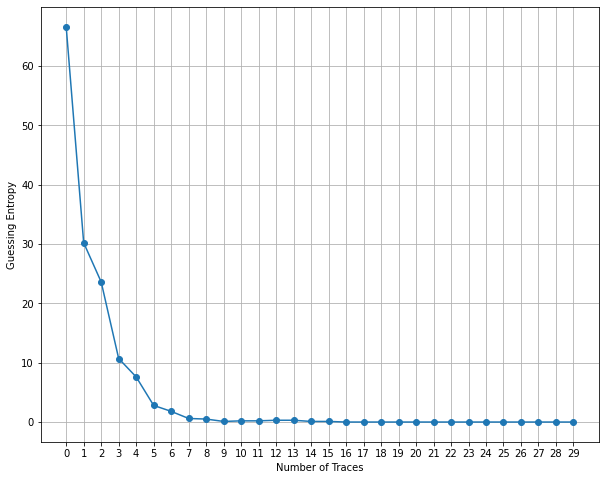

In [12]:
M = 30

f, ax = plt.subplots(figsize=(10, 8))

ax.plot(tmp_ge[:M], marker='o')
ax.set_xlabel('Number of Traces')
ax.set_ylabel('Guessing Entropy')
ax.grid()
_ = ax.set_xticks(range(M))

In [13]:
# # def ge_train(n_exp, hp, x_train_tot, y_train_tot, x_test_tot, test_plaintexts_tot, true_key_byte, byte_idx):
    
# #     num_test_traces = int(len(x_test_tot) / n_exp)

# #     ranks = []
# #     for i in tqdm(range(n_exp)):
# #         start = i * num_test_traces
# #         stop = start + num_test_traces
        
# #         x_test = x_test_tot[start:stop]
# #         test_plaintexts = test_plaintexts_tot[start:stop]
        
# #         network = build_model(hp)
# #         network.fit(x_train_tot,
# #                     y_train_tot,
# #                     epochs=EPOCHS,
# #                     batch_size=hp['batch_size'],
# #                     verbose=0)

# #         preds = network.predict(x_test)

# #         evaluator = SingleByteEvaluator(test_plaintexts=test_plaintexts,
# #                                         byte_idx=byte_idx,
# #                                         label_preds=preds)

# #         exp_ranks = []
# #         for j in range(num_test_traces):
# #             n_traces = j + 1
# #             exp_ranks.append(evaluator.rank(true_key_byte, n_traces))

# #         exp_ranks = np.array(exp_ranks)
# #         ranks.append(exp_ranks)

# #     ranks = np.array(ranks)
# #     guessing_entropy = np.mean(ranks, axis=0)

# #     return guessing_entropy




# def ge(n_exp, network, hp, x_train_tot, y_train_tot, x_test_tot, test_plaintexts_tot, true_key_byte, byte_idx, train): 
    
#     if not train:
#         network.fit(x_train_tot,
#                     y_train_tot,
#                     epochs=200,
#                     batch_size=hp['batch_size'],
#                     verbose=1)
   
#     num_test_traces = int(len(x_test_tot) / n_exp)

#     ranks = []
#     for i in tqdm(range(n_exp)):
#         start = i * num_test_traces
#         stop = start + num_test_traces
        
#         x_test = x_test_tot[start:stop]
#         test_plaintexts = test_plaintexts_tot[start:stop]
        
#         if train:
#             network = build_model(hp)
#             network.fit(x_train_tot,
#                         y_train_tot,
#                         epochs=200,
#                         batch_size=hp['batch_size'],
#                         verbose=1)
        
#         preds = network.predict(x_test)
        
#         preds_plaintexts = list(zip(preds, test_plaintexts))
#         random.shuffle(preds_plaintexts)
#         shuffled_preds = np.array([pred for pred, _ in preds_plaintexts])
#         shuffled_plaintexts = np.array([pltxt for _, pltxt in preds_plaintexts])

#         evaluator = SingleByteEvaluator(test_plaintexts=shuffled_plaintexts,
#                                         byte_idx=byte_idx,
#                                         label_preds=shuffled_preds)

#         exp_ranks = []
#         for j in range(num_test_traces):
#             n_traces = j + 1
#             exp_ranks.append(evaluator.rank(true_key_byte, n_traces))

#         exp_ranks = np.array(exp_ranks)
#         ranks.append(exp_ranks)

#     ranks = np.array(ranks)
#     guessing_entropy = np.mean(ranks, axis=0)

#     return guessing_entropy

In [14]:
# ge_only_test = ge(n_exp=10,
#                   network=best_net,
#                   hp=best_net_hp,
#                   x_train_tot=x_train_tot,
#                   y_train_tot=y_train_tot,
#                   x_test_tot=x_test,
#                   test_plaintexts_tot=test_plaintexts,
#                   true_key_byte=true_key_byte,
#                   byte_idx=BYTE_IDX,
#                   train=False)

# ge_train = ge(n_exp=10,
#               network=best_net,
#               hp=best_net_hp,
#               x_train_tot=x_train_tot,
#               y_train_tot=y_train_tot,
#               x_test_tot=x_test,
#               test_plaintexts_tot=test_plaintexts,
#               true_key_byte=true_key_byte,
#               byte_idx=BYTE_IDX,
#               train=True)

In [15]:
# N = 20
# f, ax = plt.subplots(2, 1, figsize=(12, 12))

# ax[0].plot(ge_only_test[:N], marker='o', color='r')
# ax[0].set_title('Different tests')
# ax[0].set_xlabel('Number of Traces')
# ax[0].set_ylabel('Guessing Entropy')
# ax[0].grid()
# _ = ax[0].set_xticks(range(N))

# ax[1].plot(ge_train[:N], marker='o', color='b')
# ax[1].set_title('Different trains & tests')
# ax[1].set_xlabel('Number of Traces')
# ax[1].set_ylabel('Guessing Entropy')
# ax[1].grid()
# _ = ax[1].set_xticks(range(N))

# plt.show()

In [16]:
# def ge_NEW(n_exp, hp, x_train_tot, y_train_tot, x_test_tot, test_plaintexts_tot, true_key_byte, byte_idx):
    
#     network = build_model(hp)
#     network.fit(x_train_tot,
#                 y_train_tot,
#                 epochs=200,
#                 batch_size=hp['batch_size'],
#                 verbose=1)
   
#     num_test_traces = int(len(x_test_tot) / n_exp)

#     ranks = []
#     for i in tqdm(range(n_exp)):
#         start = i * num_test_traces
#         stop = start + num_test_traces
        
#         x_test = x_test_tot[start:stop]
#         test_plaintexts = test_plaintexts_tot[start:stop]
        
#         preds = network.predict(x_test)
        
#         preds_plaintexts = list(zip(preds, test_plaintexts))
#         random.shuffle(preds_plaintexts)
#         shuffled_preds = np.array([pred for pred, _ in preds_plaintexts])
#         shuffled_plaintexts = np.array([pltxt for _, pltxt in preds_plaintexts])

#         evaluator = SingleByteEvaluator(test_plaintexts=shuffled_plaintexts,
#                                         byte_idx=byte_idx,
#                                         label_preds=shuffled_preds)

#         exp_ranks = []
#         for j in range(num_test_traces):
#             n_traces = j + 1
#             exp_ranks.append(evaluator.rank(true_key_byte, n_traces))

#         exp_ranks = np.array(exp_ranks)
#         ranks.append(exp_ranks)

#     ranks = np.array(ranks)
#     guessing_entropy = np.mean(ranks, axis=0)

#     return guessing_entropy

In [17]:
# new_ge = ge_NEW(n_exp=10,
#                 hp=best_net_hp,
#                 x_train_tot=x_train_tot,
#                 y_train_tot=y_train_tot,
#                 x_test_tot=x_test,
#                 test_plaintexts_tot=test_plaintexts,
#                 true_key_byte=true_key_byte,
#                 byte_idx=BYTE_IDX)

In [18]:
# M = 30

# f, ax = plt.subplots(figsize=(10, 8))

# ax.plot(new_ge[:M], marker='o')
# ax.set_xlabel('Number of Traces')
# ax.set_ylabel('Guessing Entropy')
# ax.grid()
# _ = ax.set_xticks(range(M))